In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-tuner
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5d3536cceae4de2f280ad1b009e23f8b9d4d3d6f710dc2e02f0eb7fbe9c57f06
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
# importing the Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras_tuner import Hyperband
import tensorflow as tf
import lime
import lime.lime_tabular

In [6]:
# load the predictive maintenance dataset
Pred_main_data = pd.read_csv('/content/drive/MyDrive/ai4i2020.csv')
Pred_main_data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


# 1. Initial Findings

In [7]:
# Remove the 'UDI' and 'Product ID' columns
Pred_main_data = Pred_main_data.drop(columns=['UDI', 'Product ID'])

In [8]:
# Encode the 'type' column categorical variables(low, mediam, high quality)
Pred_main_data['Type'] = Pred_main_data['Type'].map({'L': 0, 'M': 1, 'H': 2})

In [9]:
# statistics of the dataset
Pred_main_data.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.500300,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,0.671301,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [10]:
# Checking the missing values
print(Pred_main_data.isnull().sum())

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [11]:
# Check the data types of each column
print(Pred_main_data.dtypes)

Type                         int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


In [12]:
# print the count of target variables
Pred_main_data['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,339


# EDA


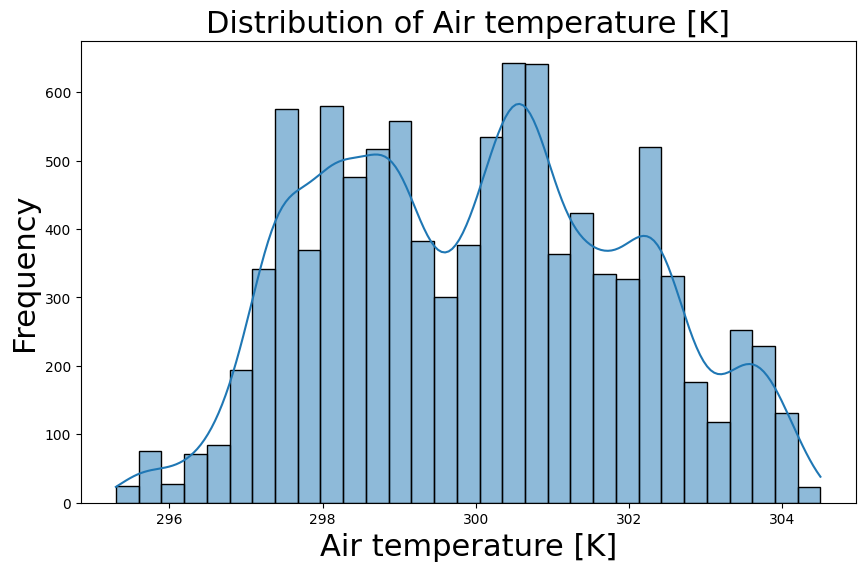

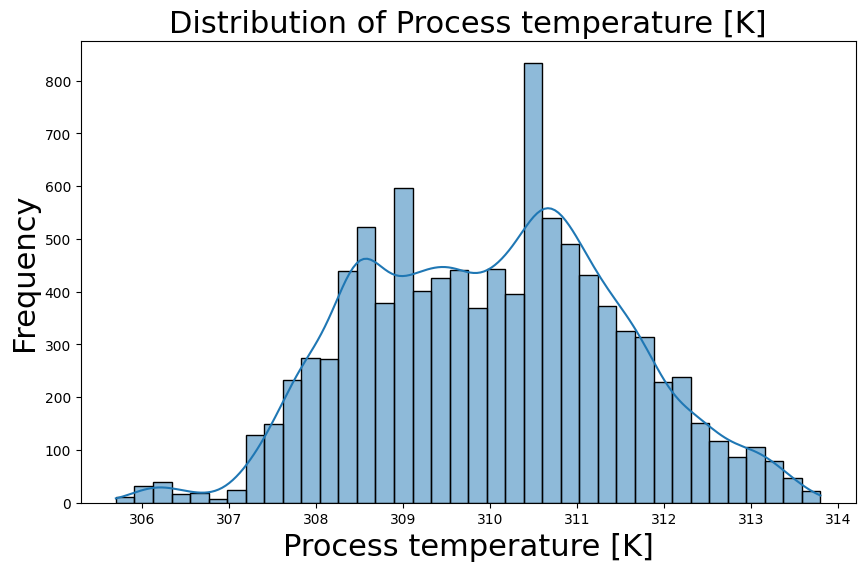

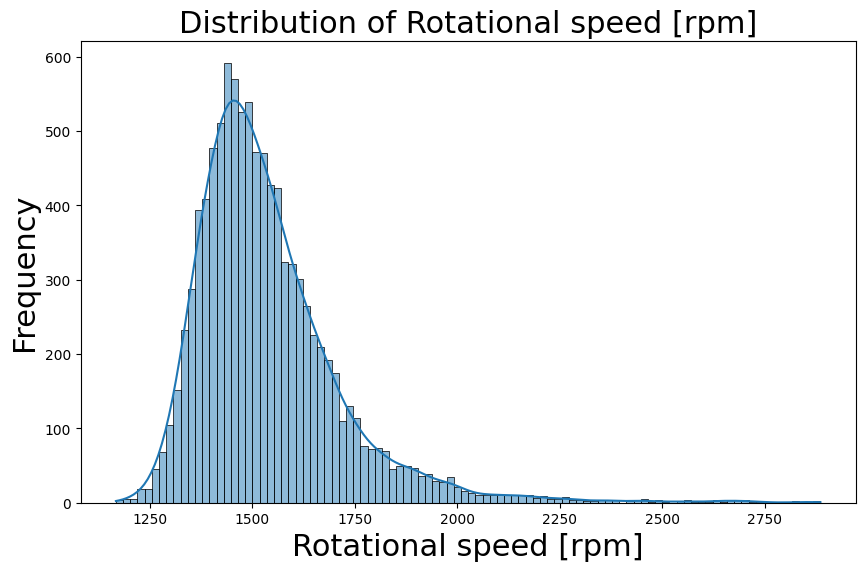

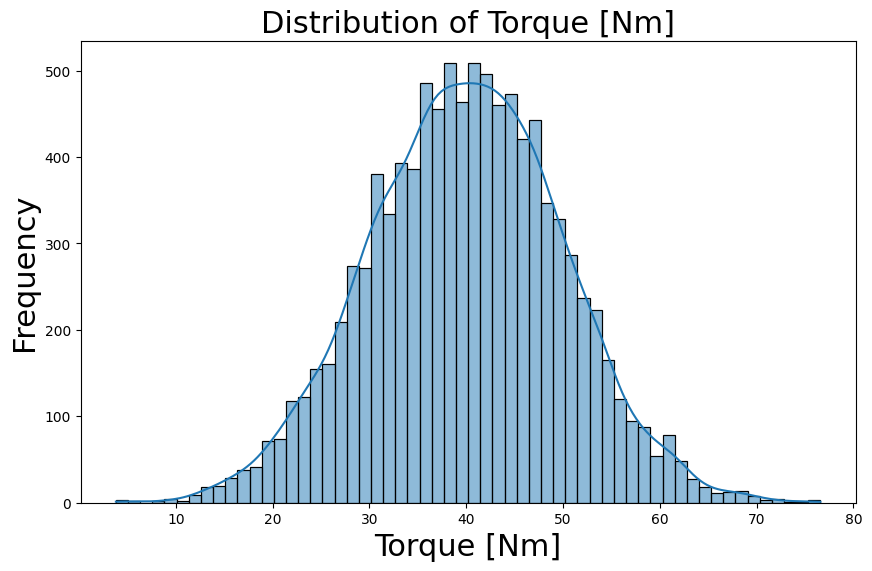

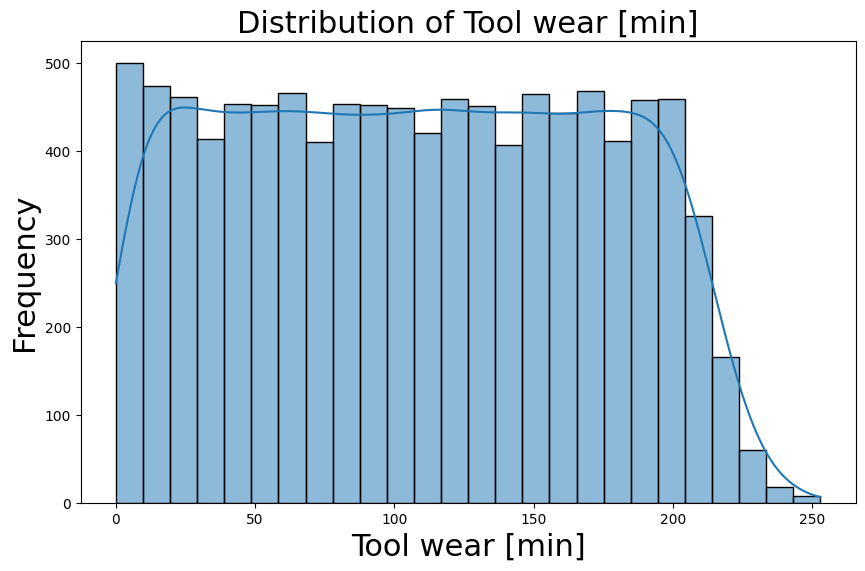

In [13]:
# List of numerical features
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(Pred_main_data[feature], kde=True)
    plt.title(f'Distribution of {feature}', fontsize=22)
    plt.xlabel(feature,fontsize=22)
    plt.ylabel('Frequency',fontsize=22)
    plt.show()

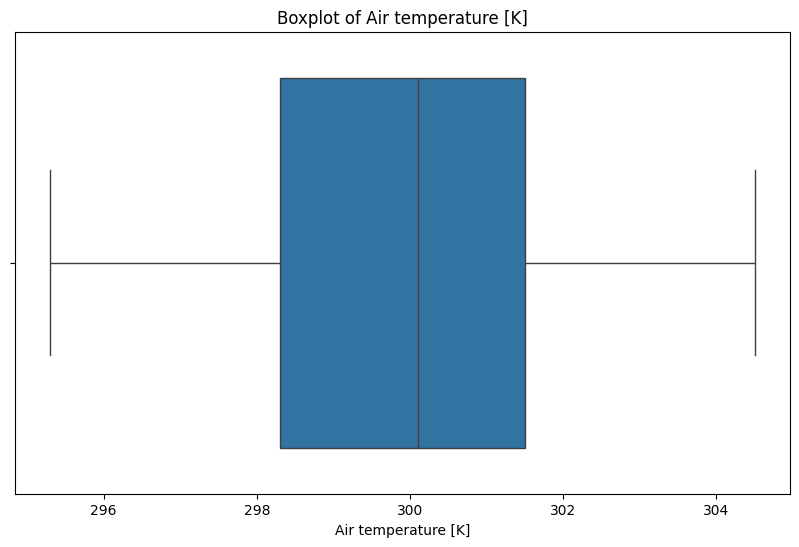

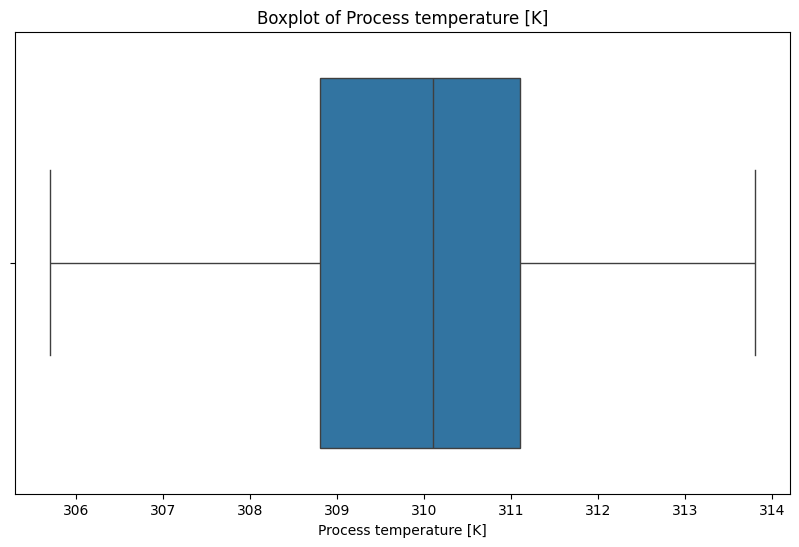

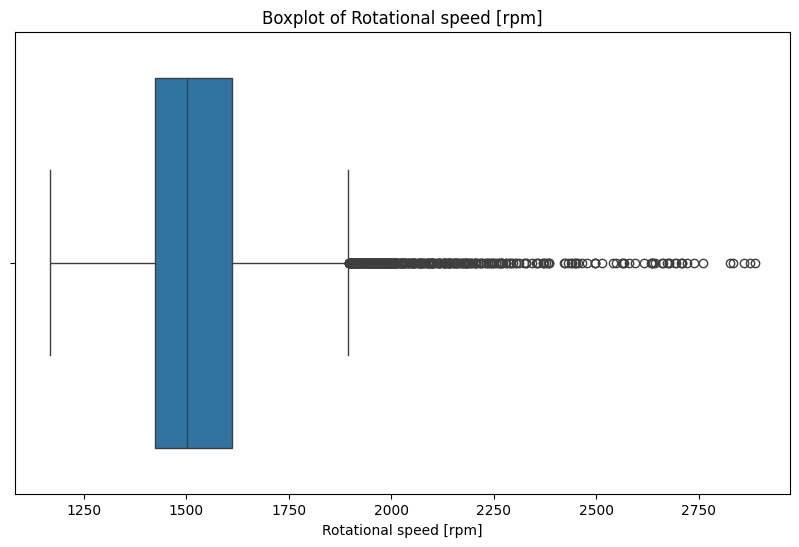

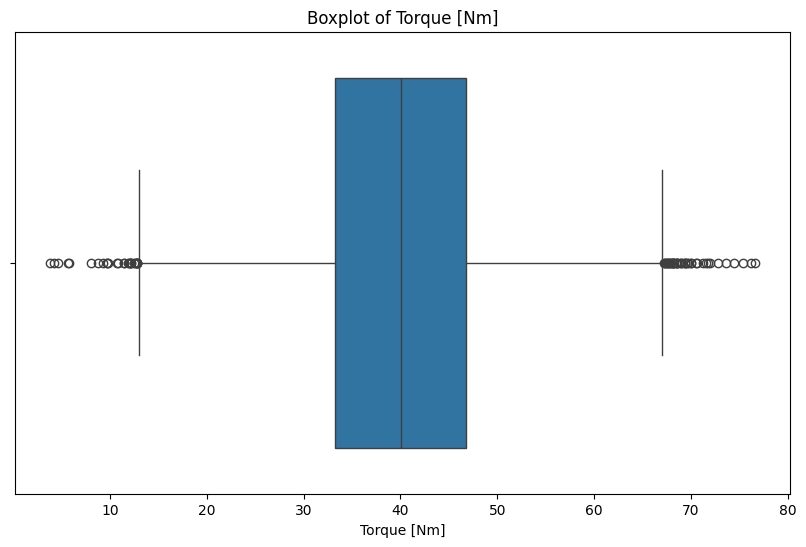

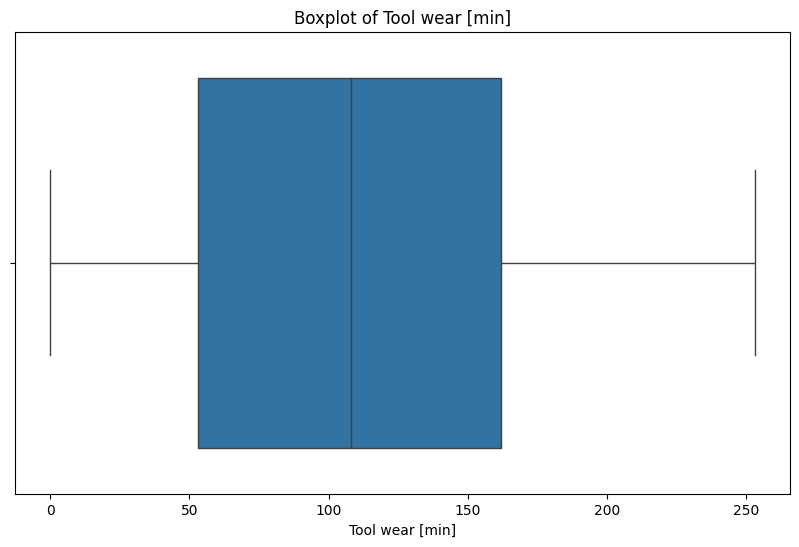

In [14]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=Pred_main_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()

In [15]:
# Define a function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from 'Rotational speed [rpm]' and 'Torque [Nm]'
df = remove_outliers(Pred_main_data, 'Rotational speed [rpm]')
df = remove_outliers(Pred_main_data, 'Torque [Nm]')

# Verify the result
print("Dataset shape after removing outliers:", df.shape)

Dataset shape after removing outliers: (9931, 12)


In [17]:
Pred_main_data['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,339


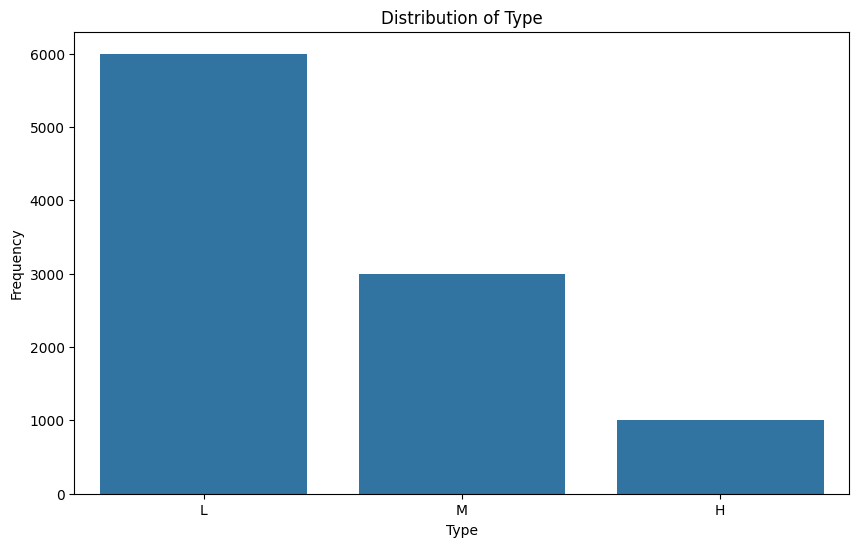

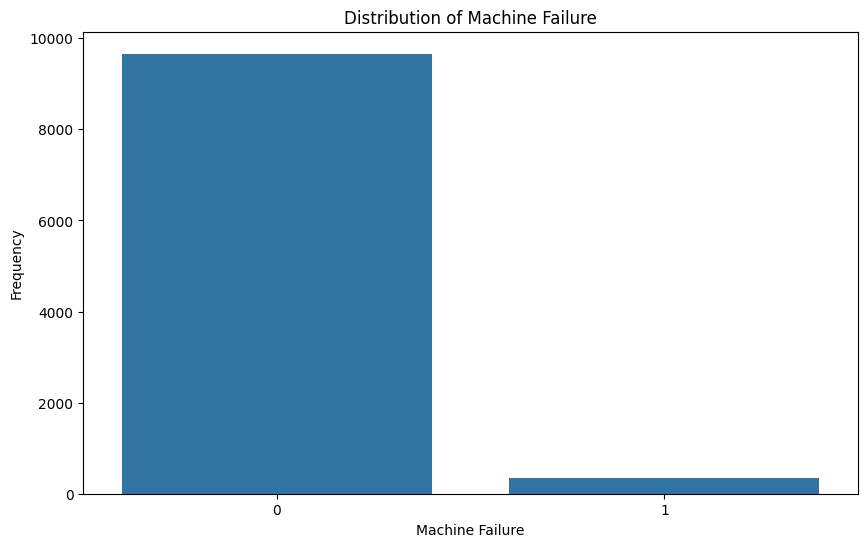

In [18]:
# Plot count plot for the 'Type' feature
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=Pred_main_data)
plt.title('Distribution of Type')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['L', 'M', 'H'])
plt.show()

# Plot count plot for the 'Machine failure' feature
plt.figure(figsize=(10, 6))
sns.countplot(x='Machine failure', data=Pred_main_data)
plt.title('Distribution of Machine Failure')
plt.xlabel('Machine Failure')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Separate features and target
X = Pred_main_data.drop(columns=['Machine failure'])
y = Pred_main_data['Machine failure']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Combine the resampled features and target into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['Machine failure'])], axis=1)

In [20]:
df_resampled['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,9661


In [21]:
df_resampled.shape

(19322, 12)

In [22]:
# Select numerical columns to normalize (excluding 'Machine failure' if it's your target variable)
numerical_cols = df_resampled.drop(columns=['Machine failure']).columns

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])

# Display the first few rows to check the normalized data
df_resampled.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,0.5,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.0,0.0,0.0,0.0,0


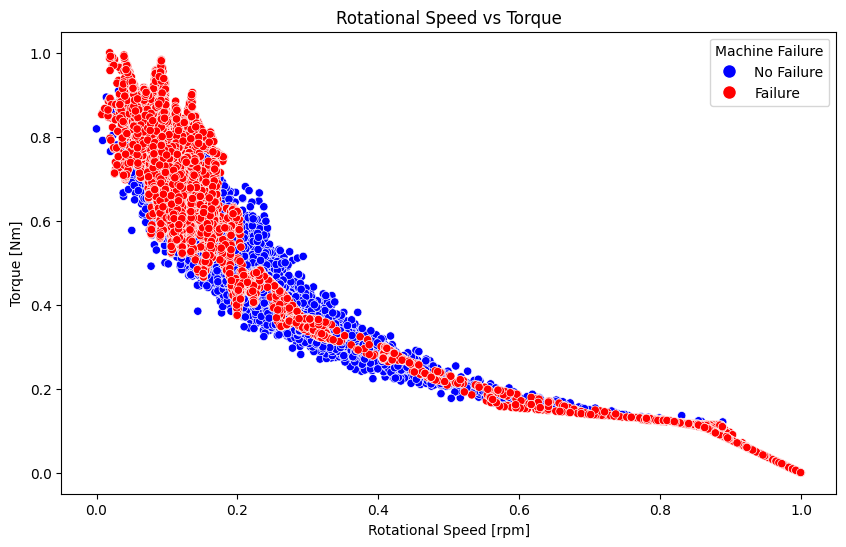

In [23]:
# Define colors for 'Failure' (red) and 'No Failure' (blue)
failure_colors = {0: 'blue', 1: 'red'}

plt.figure(figsize=(10, 6))
# Plot scatter plot with specific colors
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', hue='Machine failure', data=df_resampled,
                palette=failure_colors)

plt.title('Rotational Speed vs Torque')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')

# Create custom legend
legend_labels = ['No Failure', 'Failure']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in failure_colors.values()]
plt.legend(legend_handles, legend_labels, title='Machine Failure')

plt.show()


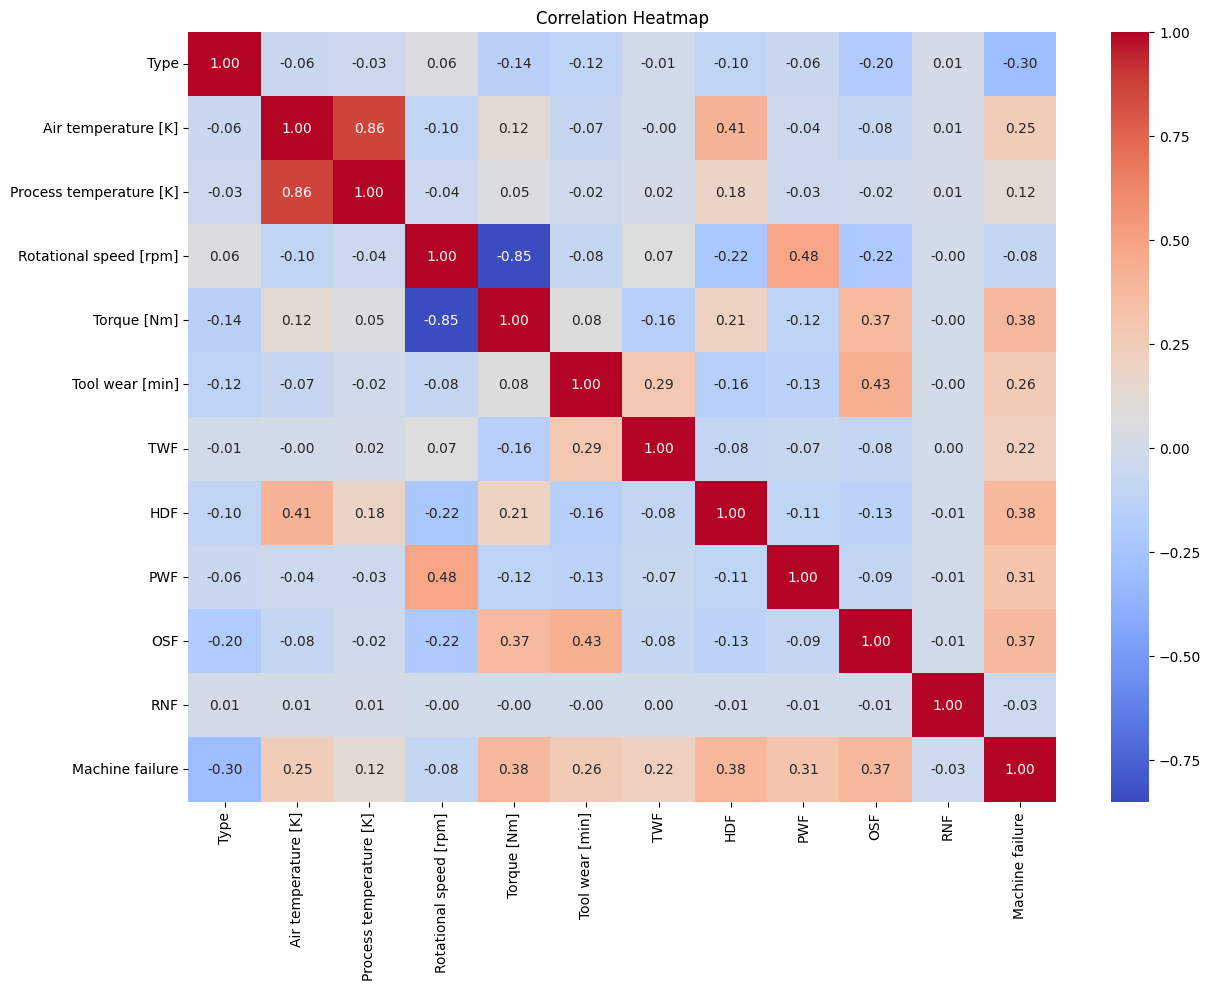

In [24]:
# Calculate the correlation matrix
correlation_matrix = df_resampled.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [25]:
# Separate features and target variable
X = df_resampled.drop(columns=['Machine failure'])
y = df_resampled['Machine failure']

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Printing the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15457, 2)
X_test shape: (3865, 2)
y_train shape: (15457,)
y_test shape: (3865,)


# Model Implementation

## Random Forest

In [ ]:
# Initialize the Random Forest model
Prmain_rf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
Prmain_rf.fit(X_train, y_train)

# Get predictions from the Random Forest model
y_pred_rf_train = Prmain_rf.predict(X_train)
y_pred_rf_test = Prmain_rf.predict(X_test)

In [ ]:
# Prepare the input for the neural network by combining original features and RF predictions
X_train_nn = np.column_stack((X_train, y_pred_rf_train))
X_test_nn = np.column_stack((X_test, y_pred_rf_test))

# Define the neural network architecture
model_rf = Sequential()
model_rf.add(Dense(64, input_dim=X_train_nn.shape[1], activation='relu'))
model_rf.add(Dense(32, activation='relu'))
model_rf.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
model_rf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
    patience=3,
    restore_best_weights=True)
# Train the neural network
rf_hystory = model_rf.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9789 - loss: 0.2850 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 3.7368e-04
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 2.8418e-04 - val_accuracy: 1.0000 - val_loss: 1.4504e-04
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.1763e-04 - val_accuracy: 1.0000 - val_loss: 7.3637e-05
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 6.2059e-05 - val_accuracy: 1.0000 - val_loss: 4.3091e-05
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.6876e-05 - val_accuracy: 1.0000 - val_loss: 2.7465e-05
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.3788e-05 - val_accuracy: 1.0000 - val_loss: 1.8534e-05
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

In [ ]:
def plot_training_history(history, title='Model Training History'):
    """
    Plots the training and validation loss and accuracy from the model's history.

    Args:
    - history: History object returned by the model's fit method.
    - title: Title of the plot (string).

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=(12, 6))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

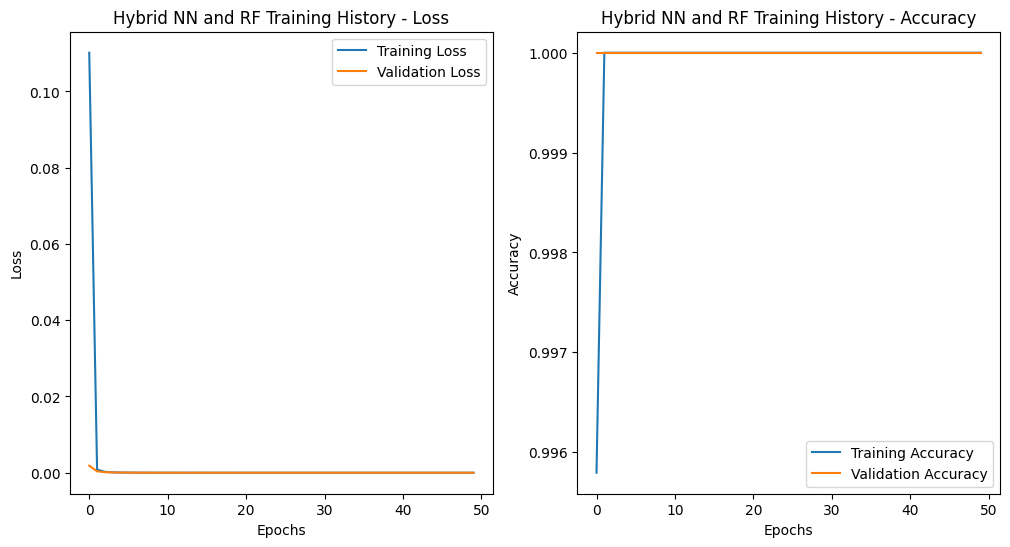

In [ ]:
plot_training_history(rf_hystory, title='Hybrid NN and RF Training History')

In [ ]:
# Predict on the test set using the neural network
y_pred_rf_test = model_rf.predict(X_test_nn)

y_pred_rf_test = (y_pred_rf_test > 0.5).astype(int)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
def evaluate_predictive_maintenance_model(y_true, y_pred):
    """
    Prints the classification report and visualizes the confusion matrix.

    Parameters:
    - y_true: Ground truth target values.
    - y_pred: Estimated targets as returned by a classifier.
    - class_names: List of class names for labeling the confusion matrix.

    Returns:
    - None
    """
    class_names = ['No Failure', 'Failure']

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.85      0.90      0.87      1934
     Failure       0.89      0.84      0.86      1931

    accuracy                           0.87      3865
   macro avg       0.87      0.87      0.87      3865
weighted avg       0.87      0.87      0.87      3865



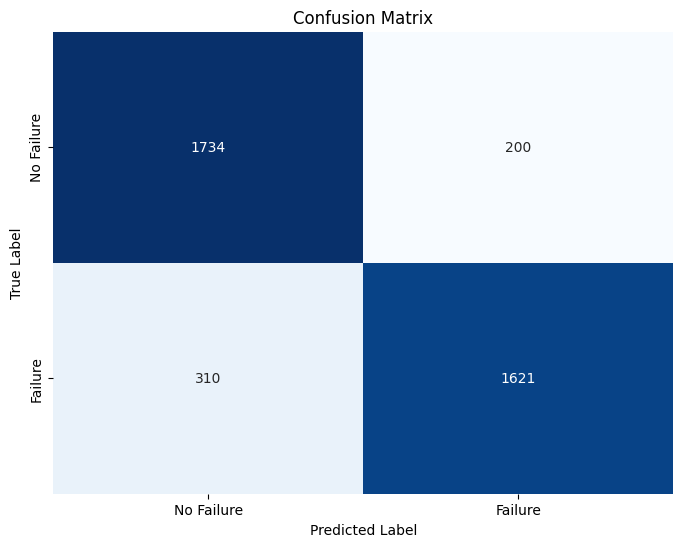

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_rf_test)

## Gradient Boosting

In [ ]:
# Initialize the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
gbc.fit(X_train, y_train)

# Get predictions from the Gradient Boosting model
y_pred_gbc_train = gbc.predict(X_train)
y_pred_gbc_test = gbc.predict(X_test)

X_train_nn_gbc = np.column_stack((X_train, y_pred_gbc_train))
X_test_nn_gbc = np.column_stack((X_test, y_pred_gbc_test))

# Define the neural network architecture
model_gbc = Sequential()
model_gbc.add(Dense(64, input_dim=X_train_nn_gbc.shape[1], activation='relu'))
model_gbc.add(Dense(32, activation='relu'))
model_gbc.add(Dense(1, activation='sigmoid'))

# Compile the model
model_gbc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
gbc_history = model_gbc.fit(X_train_nn_gbc, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict on the test set using the neural network
y_pred_nn_gbc_test = model_gbc.predict(X_test_nn_gbc)
y_pred_nn_gbc_test = (y_pred_nn_gbc_test > 0.5).astype(int)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8157 - loss: 0.4817 - val_accuracy: 0.8551 - val_loss: 0.3730
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8615 - loss: 0.3579 - val_accuracy: 0.8551 - val_loss: 0.3641
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8646 - loss: 0.3460 - val_accuracy: 0.8551 - val_loss: 0.3575
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


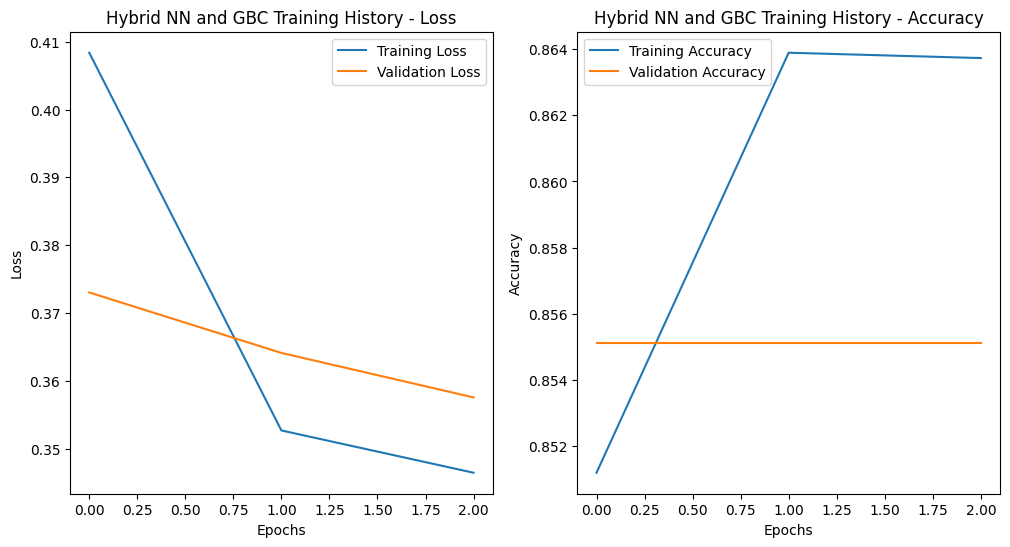

In [ ]:
plot_training_history(gbc_history, title='Hybrid NN and GBC Training History')

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.82      0.93      0.87      1934
     Failure       0.92      0.80      0.85      1931

    accuracy                           0.86      3865
   macro avg       0.87      0.86      0.86      3865
weighted avg       0.87      0.86      0.86      3865



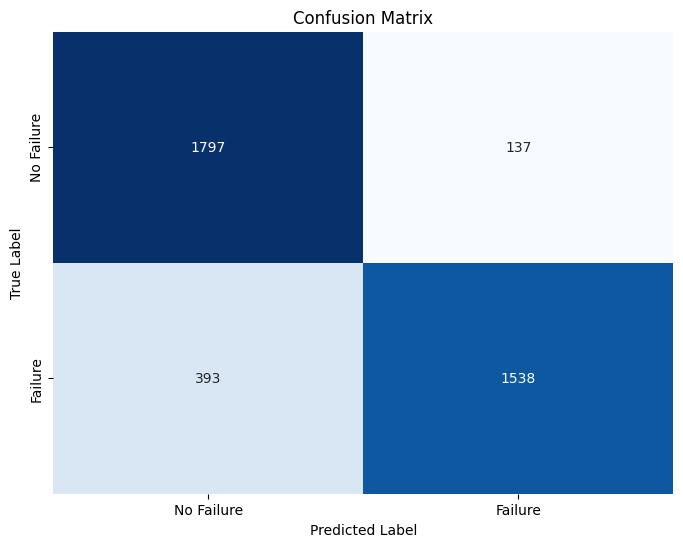

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_nn_gbc_test)

## SVM

In [ ]:
# Initialize the SVM model
svm = SVC(probability=True, random_state=42)

# Fit the model on the training data
svm.fit(X_train, y_train)

# Get predictions from the SVM model
y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

# Prepare the input for the neural network by combining original features and SVM predictions
X_train_nn_svm = np.column_stack((X_train, y_pred_svm_train))
X_test_nn_svm = np.column_stack((X_test, y_pred_svm_test))

# Define the neural network architecture
model_svm = Sequential()
model_svm.add(Dense(64, input_dim=X_train_nn_svm.shape[1], activation='relu'))
model_svm.add(Dense(32, activation='relu'))
model_svm.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
model_svm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
svm_history = model_svm.fit(X_train_nn_svm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict on the test set using the neural network
y_pred_nn_svm_test = model_svm.predict(X_test_nn_svm)
y_pred_nn_svm_test = (y_pred_nn_svm_test > 0.5).astype(int)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8397 - loss: 0.4724 - val_accuracy: 0.8376 - val_loss: 0.3835
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8453 - loss: 0.3647 - val_accuracy: 0.8383 - val_loss: 0.3720
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8496 - loss: 0.3571 - val_accuracy: 0.8386 - val_loss: 0.3709
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


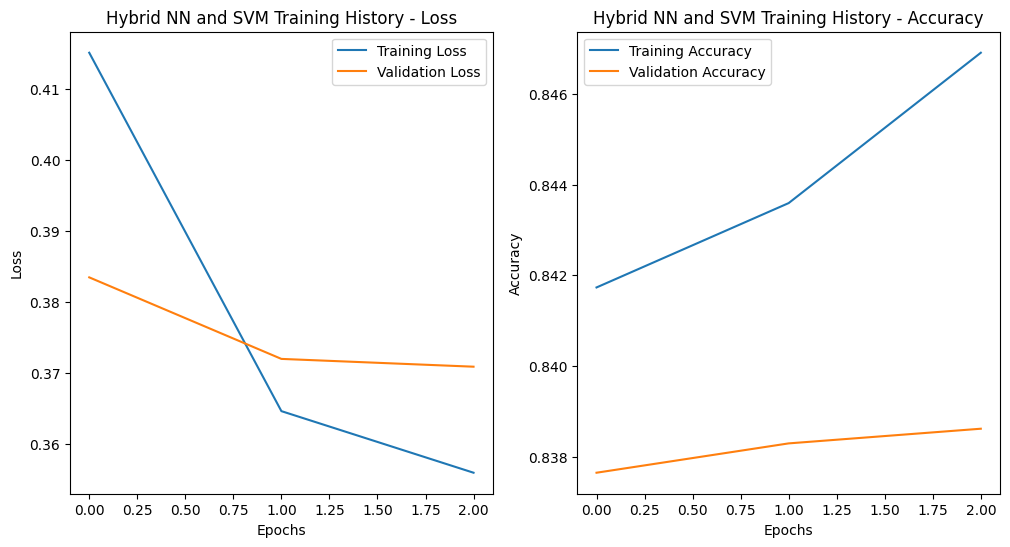

In [ ]:
plot_training_history(svm_history, title='Hybrid NN and SVM Training History')

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.80      0.94      0.86      1934
     Failure       0.93      0.76      0.84      1931

    accuracy                           0.85      3865
   macro avg       0.86      0.85      0.85      3865
weighted avg       0.86      0.85      0.85      3865



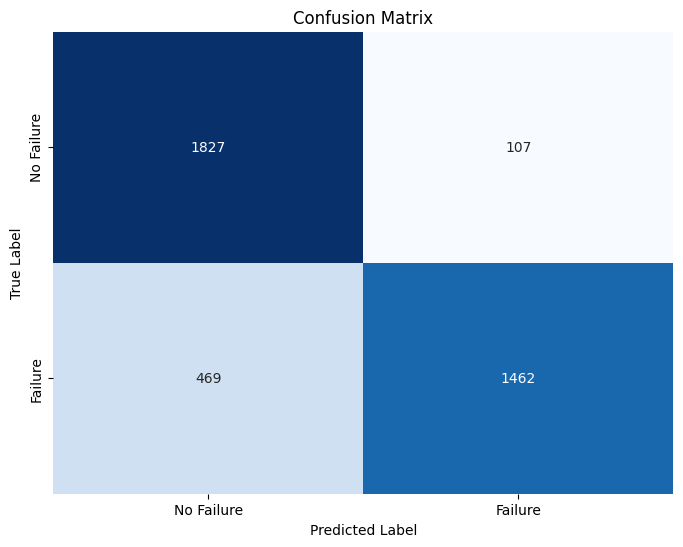

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_nn_svm_test)

## KNN

In [ ]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Get predictions from the KNN model
y_pred_knn_train = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)

# Prepare the input for the neural network by combining original features and KNN predictions
X_train_nn_knn = np.column_stack((X_train, y_pred_knn_train))
X_test_nn_knn = np.column_stack((X_test, y_pred_knn_test))

# Define the neural network architecture
model_knn = Sequential()
model_knn.add(Dense(64, input_dim=X_train_nn_knn.shape[1], activation='relu'))
model_knn.add(Dense(32, activation='relu'))
model_knn.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
model_knn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
knn_history = model_knn.fit(X_train_nn_knn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict on the test set using the neural network
y_pred_nn_knn_test = model_knn.predict(X_test_nn_knn)
y_pred_nn_knn_test = (y_pred_nn_knn_test > 0.5).astype(int)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8601 - loss: 0.4173 - val_accuracy: 0.8878 - val_loss: 0.3144
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8975 - loss: 0.2901 - val_accuracy: 0.8878 - val_loss: 0.3064
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8981 - loss: 0.2871 - val_accuracy: 0.8878 - val_loss: 0.3028
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


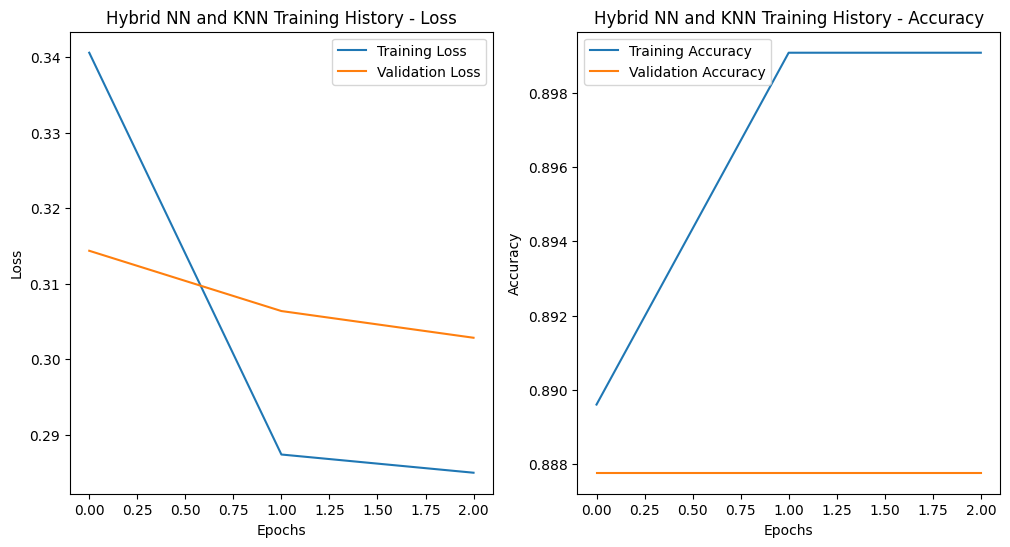

In [ ]:
plot_training_history(knn_history, title='Hybrid NN and KNN Training History')

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.85      0.87      0.86      1934
     Failure       0.86      0.85      0.86      1931

    accuracy                           0.86      3865
   macro avg       0.86      0.86      0.86      3865
weighted avg       0.86      0.86      0.86      3865



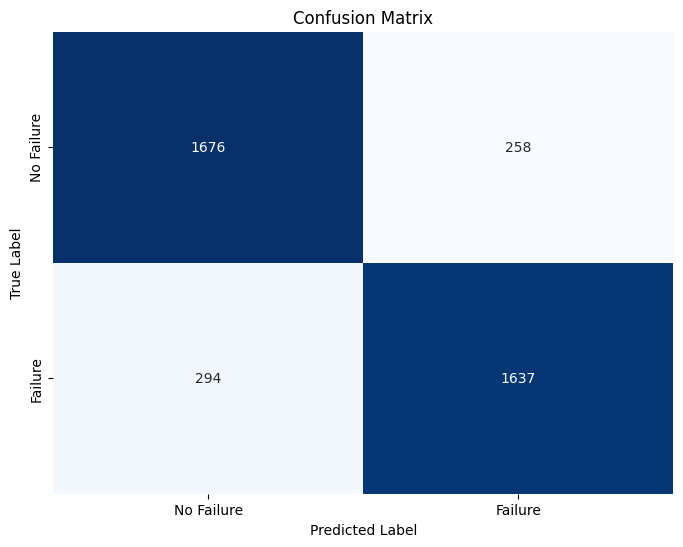

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_nn_knn_test)

## ANN

In [ ]:
# Initialize the ANN model
Prmain_ann = Sequential()
Prmain_ann.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
Prmain_ann.add(Dense(32, activation='relu'))  # Hidden layer
Prmain_ann.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
Prmain_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Fit the model on the training data
history = Prmain_ann.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7887 - loss: 0.5257 - val_accuracy: 0.8321 - val_loss: 0.3906
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8347 - loss: 0.3814 - val_accuracy: 0.8354 - val_loss: 0.3811
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.3671 - val_accuracy: 0.8399 - val_loss: 0.3815
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8470 - loss: 0.3633 - val_accuracy: 0.8383 - val_loss: 0.3771
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8501 - loss: 0.3557 - val_accuracy: 0.8412 - val_loss: 0.3762
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8463 - loss: 0.3615 - val_accuracy: 0.8373 - val_loss: 0.3705
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8396 - loss: 0.3659 - val_accuracy: 0.8409 - val_loss: 0.3689
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8431 - loss: 0.3613 - val_accuracy: 0.8357

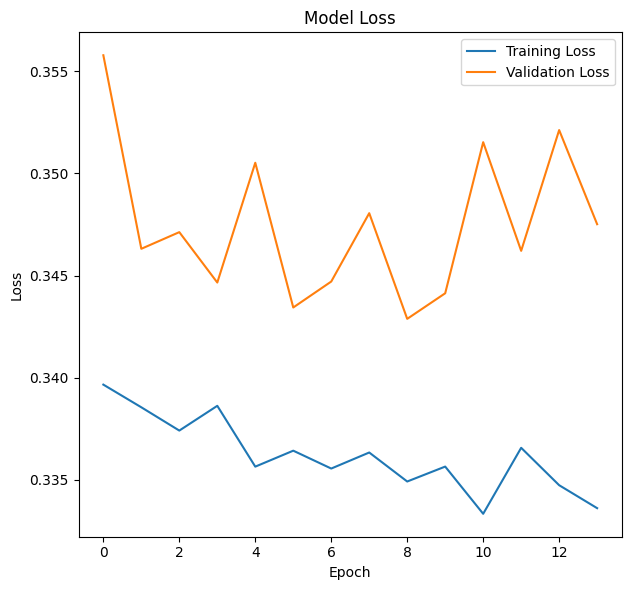

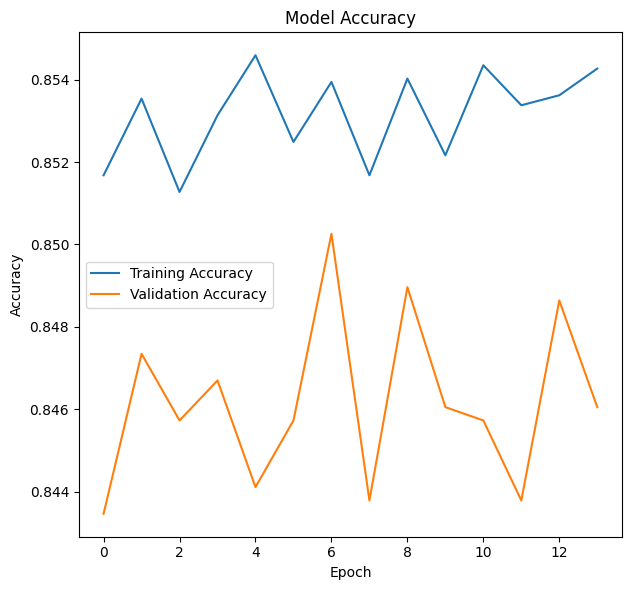

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

  No Failure       0.50      1.00      0.67      1934
     Failure       0.00      0.00      0.00      1931

    accuracy                           0.50      3865
   macro avg       0.25      0.50      0.33      3865
weighted avg       0.25      0.50      0.33      3865



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


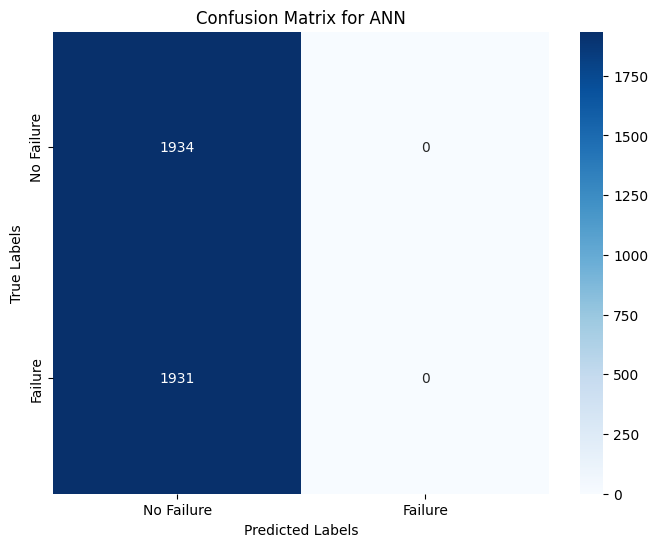

In [ ]:
# Predict on the test set
y_pred_prob_Prmain_ann = Prmain_ann.predict(X_test)
y_pred_Prmain_ann = y_pred_prob_Prmain_ann.argmax(axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_Prmain_ann, target_names=['No Failure', 'Failure']))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_Prmain_ann)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ANN')
plt.show()

# Model implementation with hyperparametertuining

## Random Forest

In [ ]:
# Define the parameter grid
rf_param_grid = {
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}


Prmain_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=Prmain_rf, param_grid=rf_param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Best Random Forest model
Prmain_best_rf = grid_search.best_estimator_

# Make predictions
y_pred_Prmain_rf_hy = Prmain_best_rf.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.84      0.92      0.88      1934
     Failure       0.91      0.83      0.87      1931

    accuracy                           0.87      3865
   macro avg       0.87      0.87      0.87      3865
weighted avg       0.87      0.87      0.87      3865



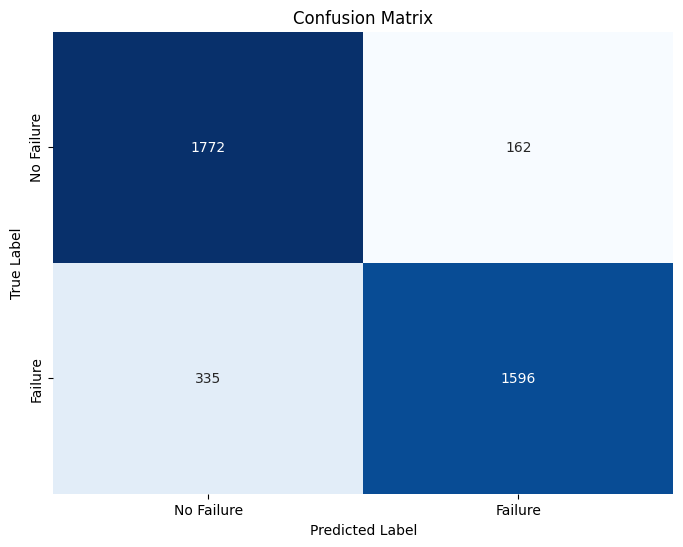

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_rf_hy)

## Gradient Boosting

In [ ]:
gb_param_grid = {
    'n_estimators': [100, 200],          # Number of boosting stages to be run
    'min_samples_split': [2, 5],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2],            # Minimum number of samples required at each leaf node
    'subsample': [0.8, 0.9],              # Fraction of samples used for fitting the individual base learners
     'learning_rate': [0.01, 0.1],        # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4]                  # Maximum depth of the individual estimators
}

# Initialize a GradientBoostingClassifier
Prmain_gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=Prmain_gb, param_grid=gb_param_grid,
                              cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_gb = grid_search_gb.best_params_
print(f"Best hyperparameters: {best_params_gb}")

# Best Gradient Boosting model
Prmain_best_gb = grid_search_gb.best_estimator_

# Make predictions
y_pred_Prmain_gb_hy = Prmain_best_gb.predict(X_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.9}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.82      0.93      0.87      1934
     Failure       0.92      0.80      0.86      1931

    accuracy                           0.86      3865
   macro avg       0.87      0.86      0.86      3865
weighted avg       0.87      0.86      0.86      3865



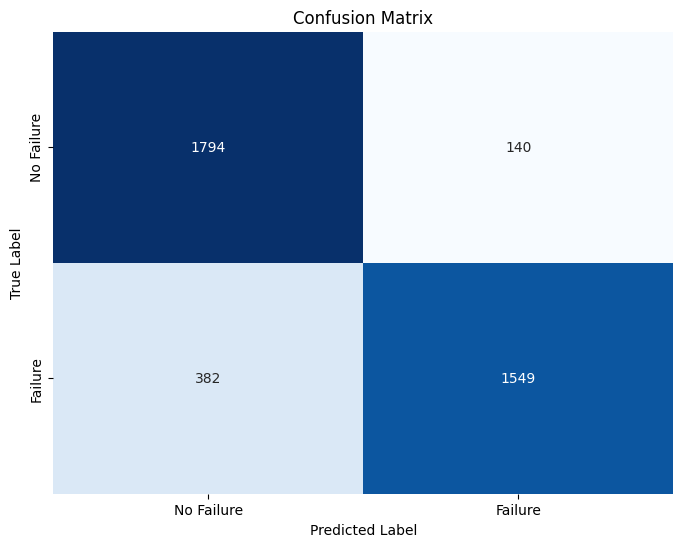

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_gb_hy)

## SVM

In [ ]:
# Define the parameter grid
svm_param_grid = {
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

# Initialize an SVC (Support Vector Classifier)
Prmain_svc = SVC()

# Initialize GridSearchCV
grid_search_svc = GridSearchCV(estimator=Prmain_svc, param_grid=svm_param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_svc.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_svc = grid_search_svc.best_params_
print(f"Best hyperparameters: {best_params_svc}")

# Best SVM model
Prmain_best_svc = grid_search_svc.best_estimator_

# Make predictions
y_pred_Prmain_svc_hy = Prmain_best_svc.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.80      0.94      0.86      1934
     Failure       0.93      0.76      0.84      1931

    accuracy                           0.85      3865
   macro avg       0.86      0.85      0.85      3865
weighted avg       0.86      0.85      0.85      3865



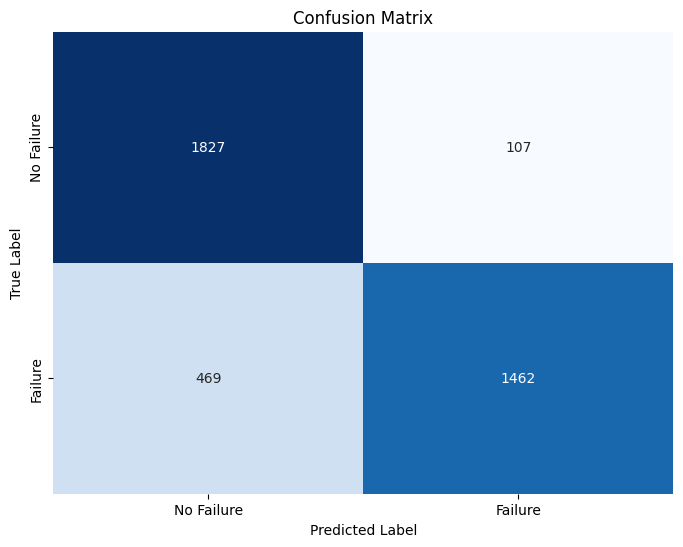

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_svc_hy)

## KNN

In [ ]:
# Define the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Initialize a KNeighborsClassifier
Prmain_knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=Prmain_knn, param_grid=knn_param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_knn.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_knn = grid_search_knn.best_params_
print(f"Best hyperparameters: {best_params_knn}")

# Best KNN model
best_knn = grid_search_knn.best_estimator_

# Make predictions
y_pred_knn_Prmain_hy = best_knn.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.86      0.87      0.86      1934
     Failure       0.87      0.86      0.86      1931

    accuracy                           0.86      3865
   macro avg       0.86      0.86      0.86      3865
weighted avg       0.86      0.86      0.86      3865



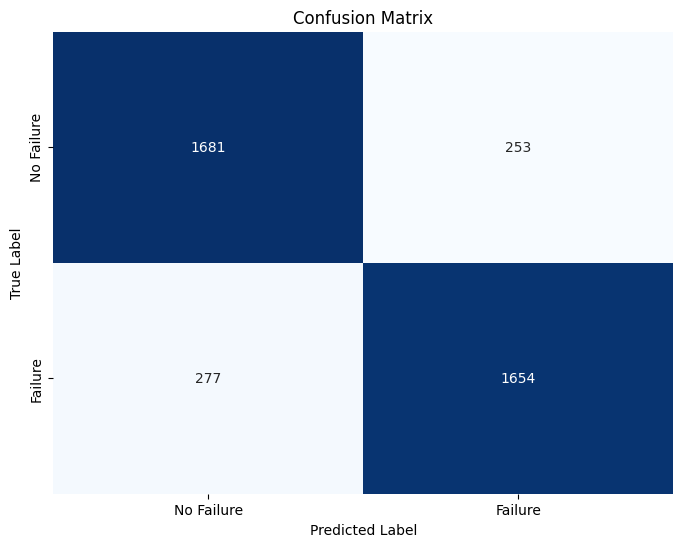

In [ ]:
evaluate_predictive_maintenance_model(y_test, y_pred_knn_Prmain_hy)

## ANN

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=1,
    directory='project_dir',
    project_name='ann_hyperparameter_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 29s]
val_accuracy: 0.8428201675415039

Best val_accuracy So Far: 0.8509055376052856
Total elapsed time: 00h 06m 26s


In [ ]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of units in first Dense layer: {best_hyperparameters.get('units1')}")
print(f"Number of units in second Dense layer: {best_hyperparameters.get('units2')}")
print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Number of units in first Dense layer: 96
Number of units in second Dense layer: 32
Learning rate: 0.004581466994406442


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8517 - loss: 0.3403 - val_accuracy: 0.8435 - val_loss: 0.3558
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8600 - loss: 0.3292 - val_accuracy: 0.8473 - val_loss: 0.3463
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.3352 - val_accuracy: 0.8457 - val_loss: 0.3471
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8559 - loss: 0.3358 - val_accuracy: 0.8467 - val_loss: 0.3447
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8522 - loss: 0.3407 - val_accuracy: 0.8441 - val_loss: 0.3505
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8500 - loss: 0.3437 - val_accuracy: 0.8457 - val_loss: 0.3434
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8550 - loss: 0.3332 - val_accuracy: 0.8503 - val_loss: 0.3447
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8502 - loss: 0.3357 - val_accuracy: 0.

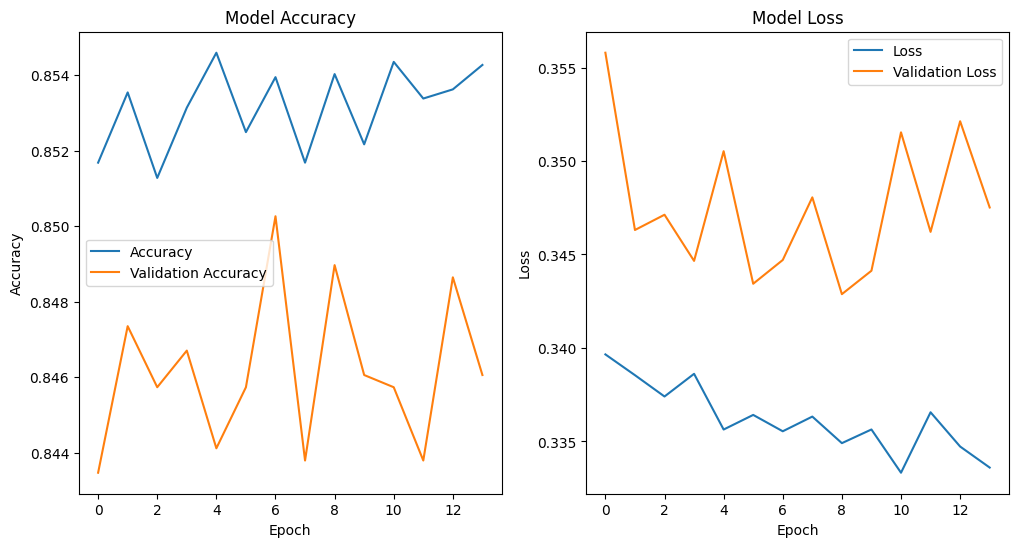

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

  No Failure       0.50      1.00      0.67      1934
     Failure       0.00      0.00      0.00      1931

    accuracy                           0.50      3865
   macro avg       0.25      0.50      0.33      3865
weighted avg       0.25      0.50      0.33      3865



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


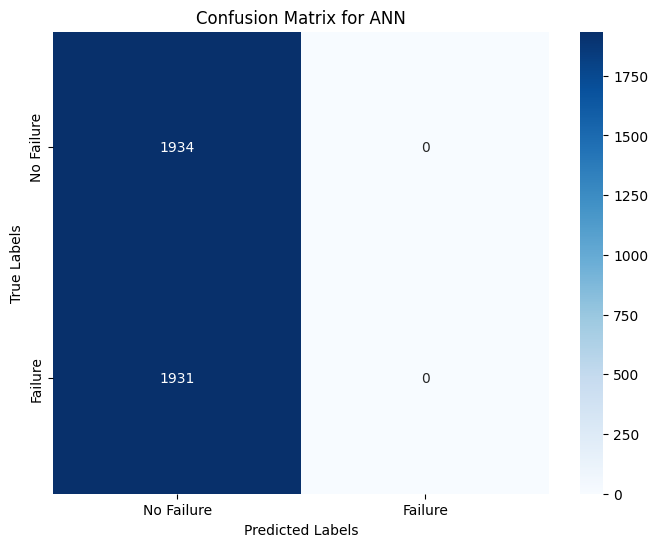

In [ ]:
# Predict on the test set
y_pred_prob_Prmain_ann = best_model.predict(X_test)
y_pred_Prmain_ann = y_pred_prob_Prmain_ann.argmax(axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_Prmain_ann, target_names=['No Failure', 'Failure']))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_Prmain_ann)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ANN')
plt.show()

# Future Importance Analysis with LIME

In [ ]:
# Separate features and target variable
X_data = df_resampled.drop(columns=['Machine failure'])
y_data = df_resampled['Machine failure']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Printing the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15457, 11)
X_test shape: (3865, 11)
y_train shape: (15457,)
y_test shape: (3865,)


In [ ]:
# Define the hyperparameters for the Random Forest model
params = {
    'bootstrap': True,
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Initialize the Random Forest model with the specified hyperparameters
Best_rf_model = RandomForestClassifier(
    bootstrap=params['bootstrap'],
    max_depth=params['max_depth'],
    min_samples_leaf=params['min_samples_leaf'],
    min_samples_split=params['min_samples_split'],
    n_estimators=params['n_estimators'],
    random_state=42  # Set a random state for reproducibility
)

# Fit the model to your training data
Best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

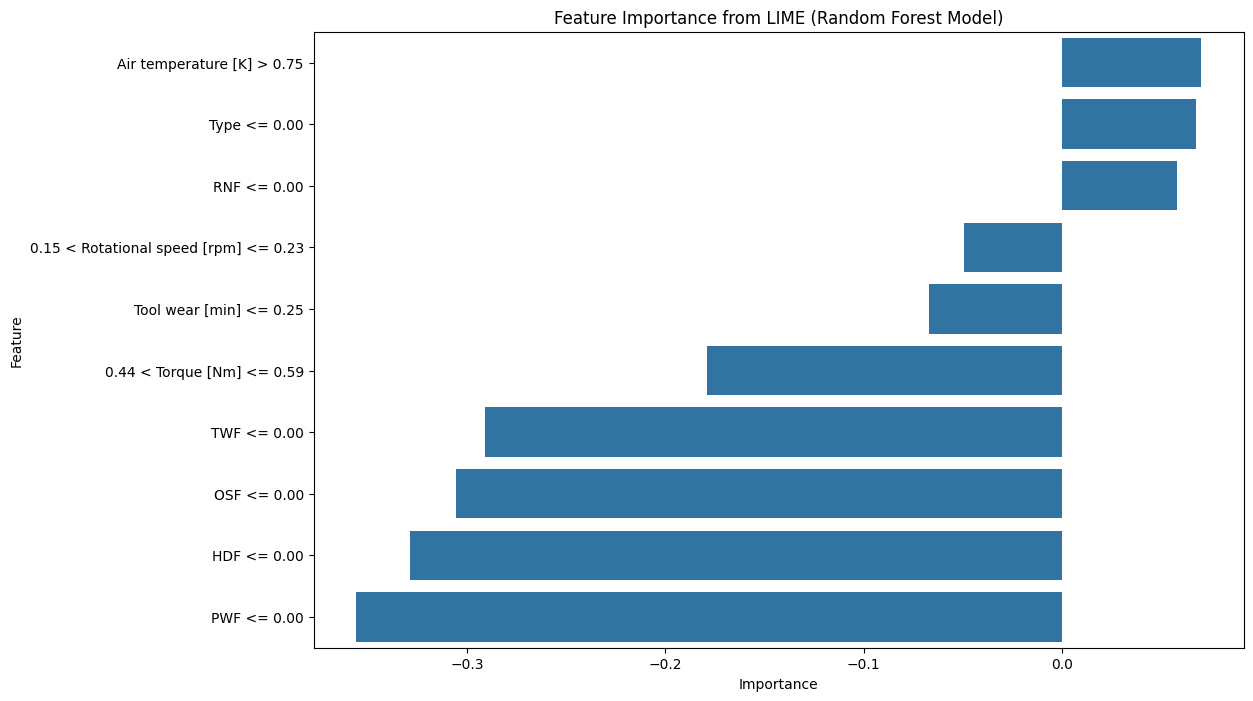

In [ ]:
# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Failed', 'Failed'],
    mode='classification'
)

instance = X_test.iloc[0]

# Generate LIME explanation for the chosen instance
lime_exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=Best_rf_model.predict_proba
)

# Visualize the LIME explanation
lime_exp.show_in_notebook(show_table=True)

# Extract feature importances from the LIME explanation
importance_df = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance using LIME values
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from LIME (Random Forest Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()